In [42]:
import pandas as pd
import numpy as np
from scipy.stats import poisson
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

zip_codes = pd.read_excel('data/SDGE_territory.xlsx', dtype=str)

years = [2018, 2019, 2020, 2021, 2022, 2023]

dfs = []

for year in years:
    file_name = f'data/DMV/DMV_{year}.csv'
    df = pd.read_csv(file_name)
    
    df.columns = [c.replace(" ", "_").lower() for c in df.columns]
    df['zip_code'] = df.zip_code.astype(str)

    df = df[df.zip_code.isin(zip_codes['ZIP_CODE'])]
    
    df = df[df.fuel == 'Battery Electric']
    dfs.append(df)


In [43]:
df = pd.concat(dfs, ignore_index=True)
df = df.groupby(['date', 'zip_code']).vehicles.sum().reset_index()
df = df.pivot(index='zip_code', columns='date', values='vehicles').fillna(0).reset_index()
df = df.melt(id_vars=['zip_code'], var_name='date', value_name='counts')

In [44]:
df.date.value_counts()
def mapping(date):
    datetime = pd.to_datetime(date)
    if datetime == pd.to_datetime('2018-10-01'):
        return 2018
    elif datetime == pd.to_datetime('2020-01-01'):
        return 2019
    elif datetime == pd.to_datetime('2021-01-01'):
        return 2020
    elif datetime == pd.to_datetime('2022-01-01'):
        return 2021
    elif datetime == pd.to_datetime('2022-12-31'):
        return 2022
    elif datetime == pd.to_datetime('2023-12-31'):
        return 2023
    
df['date'] = df.date.apply(mapping)

**obtain lambda value for each zip code**

In [45]:
import pandas as pd
import numpy as np
from scipy import stats

results = []
for zip_code in df['zip_code'].unique():
    yearly_counts = df[df['zip_code'] == zip_code]['counts'].values
    
    lambda_param = np.mean(yearly_counts)
    
    results.append({
        'zip_code': zip_code,
        'lambda': lambda_param,
        'total_registrations': sum(yearly_counts)
    })

# Create summary dataframe
summary_df = pd.DataFrame(results)
summary_df = summary_df.sort_values('lambda', ascending=False)

print("ZIP Codes and their Poisson parameters:")
print(summary_df)

ZIP Codes and their Poisson parameters:
    zip_code       lambda  total_registrations
107    92130  3121.166667              18727.0
104    92127  2316.833333              13901.0
133    92677  1988.000000              11928.0
38     92024  1657.333333               9944.0
140    92694  1626.166667               9757.0
..       ...          ...                  ...
116    92155     0.333333                  2.0
19     91948     0.333333                  2.0
56     92062     0.166667                  1.0
119    92199     0.166667                  1.0
44     92032     0.166667                  1.0

[143 rows x 3 columns]


**visualize fit for one zip code**

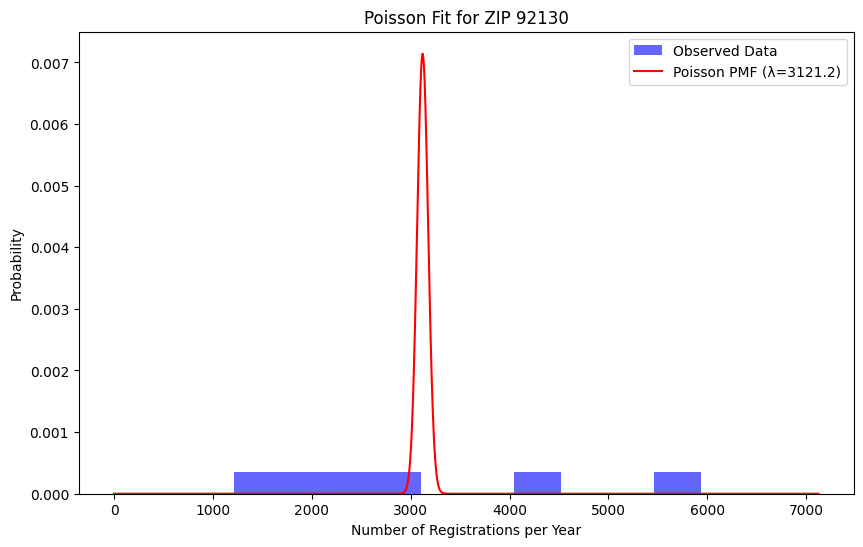

In [46]:
def plot_poisson_fit(zip_code):
    yearly_counts = df[df['zip_code'] == zip_code]['counts'].values
    lambda_param = np.mean(yearly_counts)
    
    x = np.arange(0, max(yearly_counts) * 1.2)
    poisson_pmf = stats.poisson.pmf(x, lambda_param)
    
    plt.figure(figsize=(10, 6))
    plt.hist(yearly_counts, density=True, alpha=0.6, color='blue', label='Observed Data')
    plt.plot(x, poisson_pmf, 'r-', label=f'Poisson PMF (λ={lambda_param:.1f})')
    
    plt.title(f'Poisson Fit for ZIP {zip_code}')
    plt.xlabel('Number of Registrations per Year')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

top_zip = summary_df.iloc[0]['zip_code']
plot_poisson_fit(top_zip)